# **Refit Pipeline, Model and Evaluate**

## Objectives

* Here, we will refit the pipeline with the most important features
* Fit and evaluate the ML pipeline to predict attrition

## Inputs

* Raw dataset in outputs/datasets/collection/employee-attrition.csv

## Outputs

* TrainSet and TestSet
* Data cleaning and feature engineering pipeline
* Modeling pipeline

---

# Change working directory

In [1]:
import os
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
current_dir

'/workspace/attrition-predictor'

---

# Load the dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [3]:
df = (pd.read_csv(f"outputs/datasets/collection/employee-attrition.csv")
        .drop(labels=['DailyRate','EmployeeCount', 'EmployeeNumber', 'HourlyRate',
                      'MonthlyRate', 'StandardHours', 'Over18'], axis=1))

df['Attrition'] = df['Attrition'].replace({"Yes":1, "No":0})

df.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,Sales,1,2,Life Sciences,2,Female,3,...,3,1,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,Research & Development,8,1,Life Sciences,3,Male,2,...,4,4,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,Research & Development,2,2,Other,4,Male,2,...,3,2,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,Research & Development,3,4,Life Sciences,4,Female,3,...,3,3,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,Research & Development,2,1,Medical,1,Male,3,...,3,4,1,6,3,3,2,2,2,2


From the last notebook, these are the most important features to predict attrition. We will filter the dataset such that it contains only those features.


In [4]:
best_features_and_target = [
                            'OverTime', 'YearsAtCompany', 
                            'Age', 'JobLevel', 'EnvironmentSatisfaction',
                            'Department', 'JobSatisfaction', 'StockOptionLevel',
                            'JobInvolvement', 'Attrition'
                            ]

df = df.filter(best_features_and_target)
df.head()


,OverTime,YearsAtCompany,Age,JobLevel,EnvironmentSatisfaction,Department,JobSatisfaction,StockOptionLevel,JobInvolvement,Attrition
0,Yes,6,41,2,2,Sales,4,0,3,1
1,No,10,49,2,3,Research & Development,2,1,2,0
2,Yes,0,37,1,4,Research & Development,3,0,2,1
3,Yes,8,33,1,4,Research & Development,3,0,3,0
4,No,2,27,1,1,Research & Development,2,1,3,0


Next, we will create:
* Split the dataset
* Data cleaning and feature engineering pipeline
* Handle imbalance
* Modeling pipeline

---

# Split the dataset

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Attrition'], axis=1),
                                                    df['Attrition'],
                                                    test_size=0.2,
                                                    random_state=0,
                                                   )

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(1176, 9) (1176,) (294, 9) (294,)


---

## ML Pipeline 1: Data cleaning and feature engineering pipeline

We create the datacleaning and feature engineering pipeline based on the conclusions from the last notebook.

In [6]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder
from feature_engine import transformation as vt


def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        ('yj', vt.YeoJohnsonTransformer(variables=['YearsAtCompany']) ),
        ('OrdinalCategoricalEncoder', OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Department', 'OverTime'])),
    ])

    return pipeline_base


PipelineDataCleaningAndFeatureEngineering()


Pipeline(steps=[('yj', YeoJohnsonTransformer(variables=['YearsAtCompany'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Department', 'OverTime']))])

### Fit the pipeline

In [7]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1176, 9) (1176,) (294, 9) (294,)


---

# Handle imbalance

Recap on the target imbalance mentioned in notebook 02. There is more 'No attrition' or 0's than 'Yes attrition' or 1's.

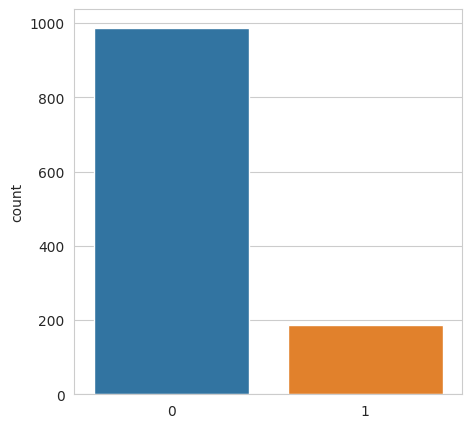

In [8]:
attrition_array = y_train.to_numpy()

def plot_target_count(target):
    fig, axes = plt.subplots(figsize=(5,5))
    sns.countplot(x = target)
    plt.show()

plot_target_count(attrition_array)

We will use Synthetic Minority Over-sampling Technique (SMOTE) from the `imblearn` library. The sampling strategy will be `minority` so it resamples all classes except the majority.

In [9]:
from imblearn.over_sampling import SMOTE

smote_over = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = smote_over.fit_resample(X_train, y_train)

We plot once again to check after SMOTE operation.

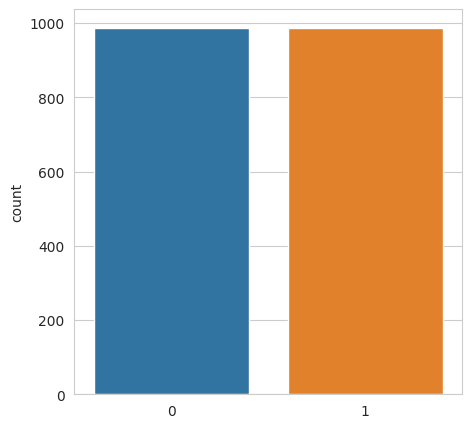

In [10]:
attrition_array_balanced = y_train.to_numpy()
plot_target_count(attrition_array_balanced)

And we notice that the traget is now balanced. One has to mind that we changed the dataset for the benefit of fitting a better model.

---

## ML Pipeline2: Modelling and Hyperparameter Optimisation pipeline

Here, the pipeline consists of:
* **StandardScaler**: to rescale the features to have standard normal distribution with zero mean and standard deviation of 1. It is performed on all variables. The variable distribution might be slightly different.
* **SelectFromModel**: to select the relevant features for fitting. We use the embedded method to perform feature selection during training. The model will be the algorithm of our choice.
* **model**: the ML algorithm

In [11]:
# Feat Scaling
from sklearn.preprocessing import StandardScaler
# Feat Selection
from sklearn.feature_selection import SelectFromModel
# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model),
    ])

    return pipeline_base

### Grid search Cross Validation

We use the custom python class for hyperparameter optimization provided by CI.

In [12]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:
    """
    Custom class provided by CI
    """
    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

We use the best classifier model (GradientBoostingClassifier) with the best hyperparameters

In [19]:
best_model = {
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
}

best_params = {
    "GradientBoostingClassifier": {
        'model__max_depth': [3],
        'model__min_samples_split': [2],
        'model__min_weight_fraction_leaf': [0.0],
        'model__n_estimators': [1000],
    },
}

Fit the pipeline to the TrainSet data. We set cross validation `cv` to 5 and we use all processors or threads by setting `n_jobs` to -1.

In [20]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=best_model, params=best_params)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Get the performance summary

In [21]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_split,model__min_weight_fraction_leaf,model__n_estimators
0,GradientBoostingClassifier,0.444444,0.877757,0.994924,0.216712,3,2,0.0,1000


Grab the pipeline

In [23]:
best_model = grid_search_summary.iloc[0,0]
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 GradientBoostingClassifier(n_estimators=1000,
                                            random_state=0))])

### Assess feature importnace

Show the features considered important for the given dataset using a certain algorithm

In [ ]:
print(X_train.columns[pipeline_clf['feature_selection'].get_support()])
print(pipeline_clf['model'].feature_importances_)

* These are the 9 most important features in descending order. The model was trained on them: 
['OverTime', 'YearsAtCompany', 'Age', 'JobLevel', 'StockOptionLevel', 'Department', 'JobInvolvement', 'EnvironmentSatisfaction', 'JobSatisfaction']


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'OverTime'),
  Text(1, 0, 'YearsAtCompany'),
  Text(2, 0, 'Age'),
  Text(3, 0, 'JobLevel'),
  Text(4, 0, 'StockOptionLevel'),
  Text(5, 0, 'Department'),
  Text(6, 0, 'JobInvolvement'),
  Text(7, 0, 'EnvironmentSatisfaction'),
  Text(8, 0, 'JobSatisfaction')])

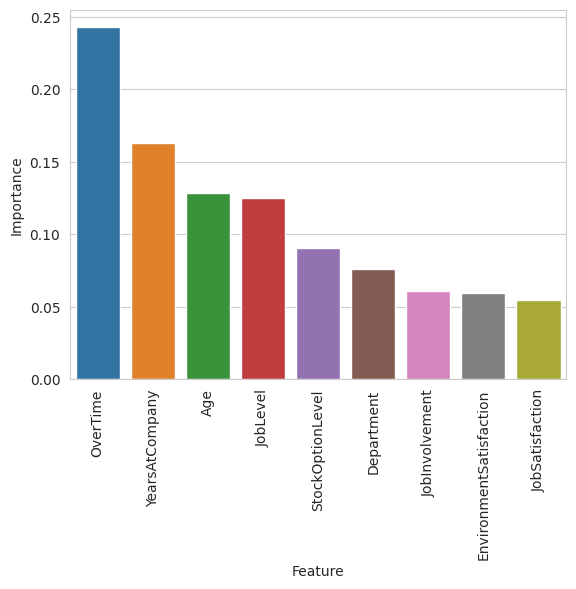

In [54]:
# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

sns.barplot(data=df_feature_importance, x="Feature", y="Importance")
plt.xticks(rotation=90)

From the 27 features, we end up with 9 important features with `OverTime` being the variable that strongly affects the target. We will use all 9 features for refitting the model. But first we evaluate the current pipeline.

---

## Evaluate the pipeline

In [25]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

In [26]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No Attrition', 'Attrition'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                        Actual No Attrition Actual Attrition
Prediction No Attrition                 981               14
Prediction Attrition                      7              974


---  Classification Report  ---
              precision    recall  f1-score   support

No Attrition       0.99      0.99      0.99       988
   Attrition       0.99      0.99      0.99       988

    accuracy                           0.99      1976
   macro avg       0.99      0.99      0.99      1976
weighted avg       0.99      0.99      0.99      1976
 

#### Test Set ####

---  Confusion Matrix  ---
                        Actual No Attrition Actual Attrition
Prediction No Attrition                 218               31
Prediction Attrition                     27               18


---  Classification Report  ---
              precision    recall  f1-score   support

No Attrition       0.88      0.89      0.88       245
   Attrition       0.40      0.3

We see that most of the model success metrics are met. These were:
* A minimum of 80% no-attrition on train and test datasets, here we get 99% and 88%, respectively
* A minimum of 60% attrition on train and test datasets, here we get 99% and 40%, respectively
* Note that the attrition prediction still does not meet the requirements (20% below). Ideally, further iterations with other models and hyperparameters can be tested. However, due to time limitation of the project, we will not proceed with further iterations.

---

## Dump the model pipeline

In [27]:
import joblib

version = 'v3'
file_path = f'outputs/ml_pipelines/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

Save the train and test datasets

In [28]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)
y_train.to_csv(f"{file_path}/y_train.csv", index=False)
X_test.to_csv(f"{file_path}/X_test.csv", index=False)
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

Dump the pipelines to pickle files

In [29]:
# Save the data cleaning and feature engineering pipeline
joblib.dump(value=pipeline_data_cleaning_feat_eng ,
            filename=f"{file_path}/clf_pipeline_data_cleaning_feat_eng.pkl")
# Save the modeling pipeline
joblib.dump(value=pipeline_clf ,
            filename=f"{file_path}/clf_pipeline_model.pkl")

['outputs/ml_pipelines/v3/clf_pipeline_model.pkl']

Feature importance was one of the business requirement, therefore, we plot it and save the file.

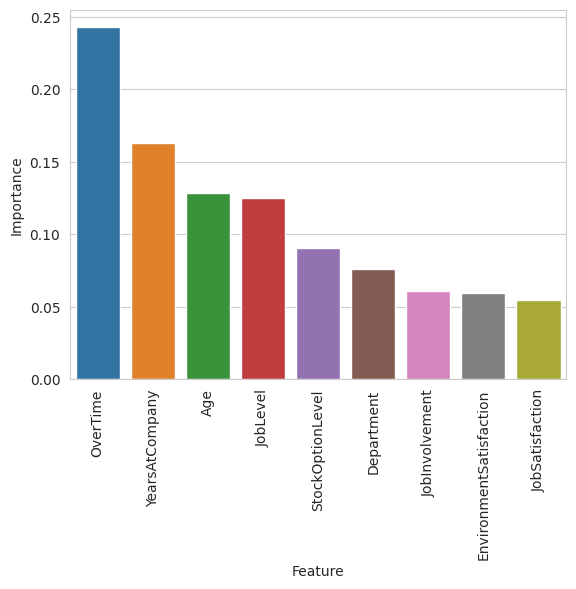

In [55]:
sns.barplot(data=df_feature_importance, x="Feature", y="Importance")
plt.xticks(rotation=90)
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

We notice that 5 of the 9 variables remained in the same ranking from the last iteration (previous notebook). Namely, the first 4 variables and `Department`. The other 4 variables have shuffled in between each other.

---

# Conclusions

* The final data cleaning and feature engineering as well as modeling pipelines were generated
* The model can predict no-attrition reliably but other iteratons or more data in the dataset is needed to predict attrition better